In [1]:
import sys
sys.path.append('..')
from pathlib import Path
from datetime import datetime
from dateutil import tz

import matplotlib.patches as mpatches
import geopandas
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from metpy.plots import USCOUNTIES

from Map import Map

## Select Parameters in the cell below

In [7]:
SPC_DAY = 2
LOCATION = 'florida'
STATE_MASK = 'FL'

In [8]:
def get_gdf(day, state_mask):
    '''Get SPC Day n shapefile and apply U.S. state mask'''
    # Read in US States Shapefile
    gdf_mask = geopandas.read_file('../../gis/tl_2017_us_state/tl_2017_us_state.shp')
    
    if SPC_DAY <= 3:
        return geopandas.read_file(f'https://www.spc.noaa.gov/products/outlook/day{day}otlk-shp.zip', 
                                   mask=gdf_mask[gdf_mask.STUSPS==state_mask.upper()])
    else:
        return geopandas.read_file(f'https://www.spc.noaa.gov/products/exper/day4-8/day{day}prob-shp.zip')

cat_gdf = get_gdf(SPC_DAY, STATE_MASK)
cat_gdf

/Users/rhawthorne/miniconda3/envs/metpy_v1/lib/python3.9/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


,DN,VALID,EXPIRE,ISSUE,LABEL,LABEL2,stroke,fill,geometry
0,2,202206041200,202206051200,202206031730,TSTM,General Thunderstorms Risk,#55BB55,#C1E9C1,"MULTIPOLYGON (((-96.91978 27.30006, -97.91000 ..."
1,3,202206041200,202206051200,202206031730,MRGL,Marginal Risk,#005500,#66A366,"MULTIPOLYGON (((-101.61000 38.57000, -101.5600..."


In [9]:
def convert_datetime_from_spc_to_local(string):
    from_zone = tz.gettz('UTC')
    to_zone = tz.gettz('America/New_York')
    utc_time = datetime.strptime(string, '%Y%m%d%H%M').replace(tzinfo=from_zone)
    eastern = utc_time.astimezone(to_zone)
    date_time = datetime.strftime(eastern, '%a, %b %d, %Y %I:%M %p').lstrip('0').replace(' 0', ' ')
    return date_time

def get_valid_day(string):
    from_zone = tz.gettz('UTC')
    to_zone = tz.gettz('America/New_York')
    utc_time = datetime.strptime(string, '%Y%m%d%H%M').replace(tzinfo=from_zone)
    eastern = utc_time.astimezone(to_zone)
    valid_day = datetime.strftime(eastern, '%A').lstrip('0').replace(' 0', ' ')
    return valid_day

def get_outlook_valid_time_info():
    start_time = cat_gdf.iloc[0]['VALID']
    end_time = cat_gdf.iloc[0]['EXPIRE']
    
    valid_day = get_valid_day(start_time)
    start_time = convert_datetime_from_spc_to_local(start_time)
    end_time = convert_datetime_from_spc_to_local(end_time)
    
    return { 
        'valid_day': valid_day,
        'start_time': start_time,
        'end_time': end_time
    }

In [10]:
def spc_outlook_categories():
    cat_plot_colors = {
        'General Thunderstorms Risk': ('palegreen', 'Non-Severe'),
        'Marginal Risk': ('green', 'Isolated'),
        'Slight Risk': ('yellow', 'Scattered'),
        'Enhanced Risk': ('orange', 'Numerous'),
        'Moderate Risk': ('red', 'Widespread'),
        'High Risk': ('magenta', 'Extreme')
    }

    cat_plot_colors_days4to8 = {
        '15% Any Severe Risk': ('yellow', 'Scattered'),
        '30% Any Severe Risk': ('orange', 'Numerous')
    }
    
    return cat_plot_colors_days4to8 if SPC_DAY >= 4 else cat_plot_colors

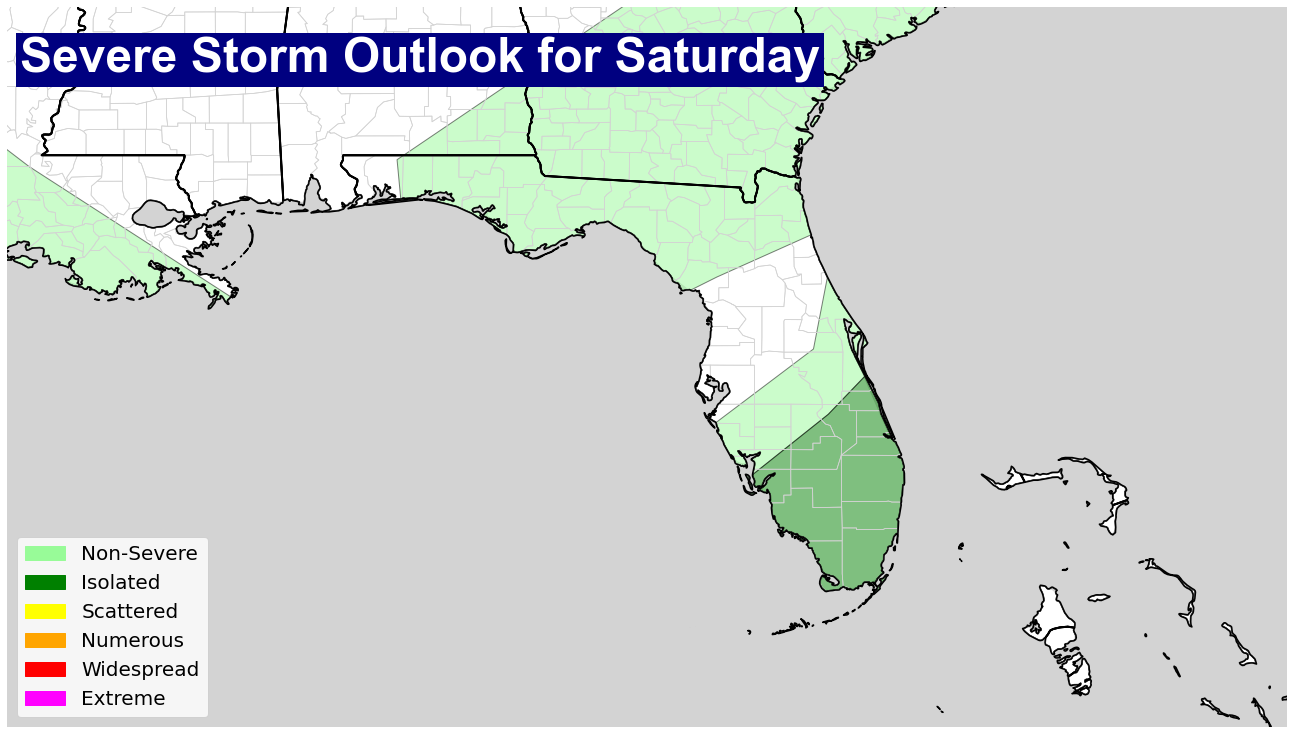

In [11]:
def plot_legend(ax):
    cat_plot_colors = spc_outlook_categories()
    legend_patches = []
    for key in cat_plot_colors.keys():
        patch = mpatches.Patch(color=cat_plot_colors[key][0], label=cat_plot_colors[key][1])
        legend_patches.append(patch)
    ax.legend(handles=legend_patches, fontsize=20, loc='lower left').set_zorder(15)
    
def save_map_to_disk(fig):
    GRAPHICS_DIR = Path('.') / '..' / '..' / 'graphics' / 'spc'
    fig.savefig(f'{GRAPHICS_DIR}/spc_day{SPC_DAY}_{LOCATION.lower()}.png', dpi=72)

def any_risk_areas(geometries):
    '''Checks to see if there are any areas flagged for tropical development'''
    return True if cat_gdf['geometry'].any() else False

def plot_risk_areas():
    new_map = Map(LOCATION)
    new_map.add_counties()
    new_map.add_title(f'Severe Storm Outlook for {get_outlook_valid_time_info()["valid_day"]}')

    fig, ax = new_map.make_map()
    
    cat_plot_colors = spc_outlook_categories()
    for key in cat_plot_colors.keys():
        geometries = cat_gdf[cat_gdf['LABEL2'] == key]
        ax.add_geometries(geometries['geometry'], crs=ccrs.PlateCarree(),
                          facecolor=cat_plot_colors[key][0], edgecolor='black',
                          alpha=0.5)
    conceal_outlook_over_ocean(ax)
    plot_legend(ax)
    save_map_to_disk(fig)
        
def conceal_outlook_over_ocean(ax):
    ax.add_feature(cfeature.OCEAN.with_scale('10m'), color='lightgray', zorder=9)
    ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=1.5, zorder=10)
        
def plot_spc_outlook():
    if not any_risk_areas(cat_gdf['geometry']):
        return
    plot_risk_areas()
    
    
plot_spc_outlook()